In [1]:
import os

os.chdir(os.path.join(os.getcwd(),'..'))
os.getcwd()

'/media/user/T7 Touch/Stage_Lucas/segmentation'

In [2]:
from src.nets import UNet
from src.downloads import download_data, unzip_data
from src.datasets2 import WarwickQU_Segmentation_Dataset
from src.training import train_UNet, EarlyStopping
from src.segmentation import post_processing
from src.visualization import plot_mini_batch

import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
import albumentations as alb

#### Datasets and Dataloaders options

In [3]:
batch_size = 4

CHANNELS = 3
NORMALIZED = True

Train = WarwickQU_Segmentation_Dataset(size=(512,768), channels=CHANNELS, normalize=NORMALIZED, transforms=None, type='train')
Cell_train, Cell_val = random_split(Train, [0.8, 0.2])

train_loader = DataLoader(Cell_train, batch_size, shuffle=True)
val_loader = DataLoader(Cell_val, batch_size, shuffle=True)

Test = WarwickQU_Segmentation_Dataset(size=(512,768), channels=CHANNELS, normalize=NORMALIZED, transforms=None, type='test')  # test mode

test_loader = DataLoader(Test, batch_size, shuffle=False)

#### Model's parameters

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = UNet(3, 64, 2)
EPOCHS = 100
STORE = 1
LR = 0.005
OPTIM = torch.optim.SGD(model.parameters(),
                                 lr=LR, momentum=0.95,
                                 weight_decay=1e-4)

STOPPER = EarlyStopping(10)

SCHEDUL = torch.optim.lr_scheduler.OneCycleLR(OPTIM, 
                                                max_lr = 1e-1,
                                                steps_per_epoch=len(train_loader),
                                                epochs=EPOCHS, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

cuda


#### Training and loss plots

In [ ]:
train_loss, val_loss, train_acc, val_acc, dices, ious = train_UNet(model, device, OPTIM, train_loader, val_loader, None, None, EPOCHS)

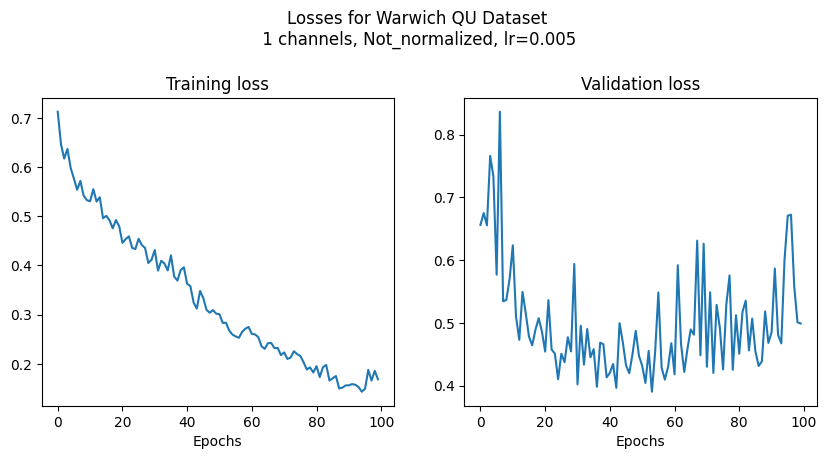

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(train_loss)
ax2.plot(val_loss)

ax1.set_title('Training loss')
ax2.set_title('Validation loss')

ax1.set_xlabel('Epochs')
ax2.set_xlabel('Epochs')

if NORMALIZED:
    NORMALIZED = 'Normalized'
else:
    NORMALIZED = 'Not_normalized'
fig.suptitle(f'Losses for Warwich QU Dataset\n {CHANNELS} channels, {NORMALIZED}, lr={LR}', y=1.1);

In [7]:
plt.savefig(f'experiments/warwick_{CHANNELS}C_{NORMALIZED}.png')

<Figure size 640x480 with 0 Axes>

In [8]:
dic = {'train_loss': train_loss, 'val_loss': val_loss, 'train_acc': train_acc, 'val_acc': val_acc, 'dice': dices, 'IoU': ious}
df = pd.DataFrame(dic)
df.to_csv(f'experiments/warwick_{CHANNELS}C_{NORMALIZED}.csv')

In [7]:
torch.save(model.state_dict(), f'{os.getcwd()}/src/models/unet_warwick_005.pth')
# model_trained = UNet(1, 64, 2)
# model_trained.load_state_dict(torch.load(f'{os.getcwd()}/src/models/unet_model.pth'))
# model = model_trained

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

#### Test predictions

In [16]:
final_imgs = torch.zeros((len(Test),3,512,768))
final_pred = torch.zeros((len(Test), 512,768))
model = model.to(device)
model.eval()
for i,imgs_test in enumerate(test_loader):
    imgs_test = imgs_test.to(device, dtype=torch.float32)

    with torch.no_grad():
        scores = model(imgs_test)
        preds = torch.argmax(scores, dim=1).float()

    for j in range(len(preds)):
        final_imgs[i*batch_size+j,:,:,:] = imgs_test[j]
        final_pred[i*batch_size+j] = preds[j]

final_imgs = final_imgs.cpu()
final_pred = final_pred.cpu()

In [17]:
last = post_processing(final_pred, binary=False)

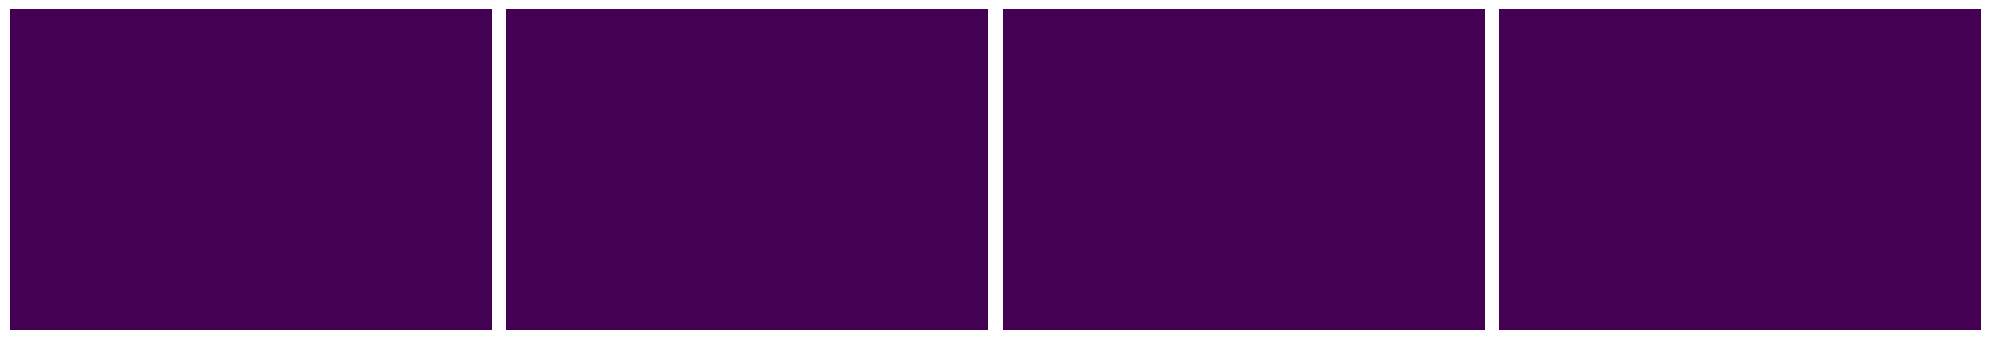

In [18]:
plot_mini_batch(final_pred[:4])

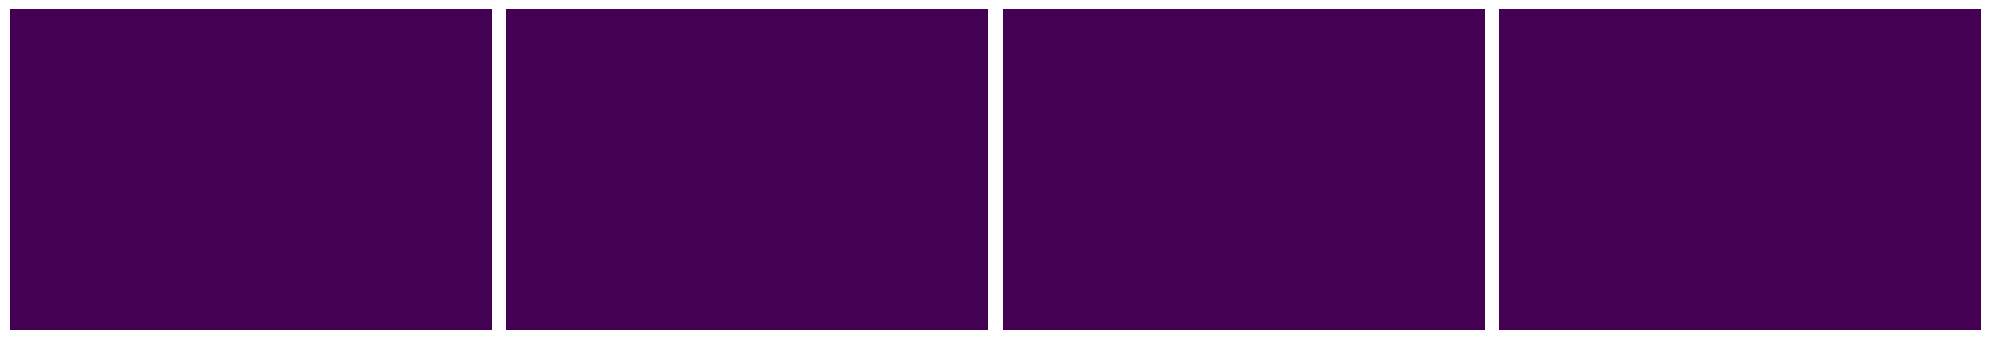

In [19]:
plot_mini_batch(last[:4])

In [ ]:
plot_mini_batch(final_imgs[:4])